# import libraries

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

from torchsummary import summary

import time
import sys
import os
os.environ['KMB_DUBLICATE_LIB_OK']='true'

C:\Users\ayxan\AppData\Local\Temp\ipykernel_15700\748224698.py:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# create Gaussian blurs

In [4]:
NumperClass=1000
imgsize=91

x=np.linspace(-4,4,imgsize)
X,Y=np.meshgrid(x,x)

widths=[1.8,2.4]
images=torch.zeros(2*NumperClass,1,imgsize,imgsize)
labels=torch.zeros(2*NumperClass)

for i in range(2*NumperClass):
    
    ro=2*np.random.randn(2)
    G=np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2 )/ (2*widths[i%2]**2))
    
    G=G+np.random.randn(imgsize,imgsize)/5
    
    images[i,:,:,:]=torch.Tensor(G).view(1,imgsize,imgsize)
    labels[i]=i%2
    
labels=labels[:,None]

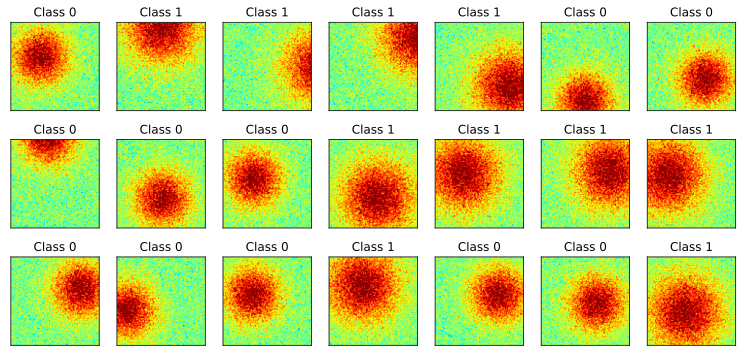

In [5]:
fig,axs=plt.subplots(3,7,figsize=(13,6))

for ax in axs.flatten():
    index=np.random.randint(2*NumperClass)
    G=np.squeeze(images[index,:,:])
    ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
    ax.set_title('Class %s'%int(labels[index].item()))
    ax.set_xticks([])
    ax.set_yticks([])    

In [37]:
trainData,devtest_data,trainLabel,devtest_label=train_test_split(
                        images,labels,train_size=.9)

dev_data,test_data,dev_label,test_label=train_test_split(
                        devtest_data,devtest_label,test_size=.5)

#create datasets
train_dataset=TensorDataset(trainData,trainLabel)
dev_dataset=TensorDataset(dev_data,dev_label)
test_dataset=TensorDataset(test_data,test_label)

#create data loaders
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True,drop_last=True)
dev_loader=DataLoader(dev_dataset,batch_size=dev_dataset.tensors[0].shape[0])
test_loader=DataLoader(test_dataset,batch_size=test_dataset.tensors[0].shape[0])

print(f'train_loader shape: {train_loader.dataset.tensors[0].shape}')
print(f'dev_loader shape: {dev_loader.dataset.tensors[0].shape}')
print(f'test_loader shape: {test_loader.dataset.tensors[0].shape}')

train_loader shape: torch.Size([1800, 1, 91, 91])
dev_loader shape: torch.Size([100, 1, 91, 91])
test_loader shape: torch.Size([100, 1, 91, 91])


# create cnn model

In [31]:
def createModel():
    class cnnModel(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.network=nn.Sequential(
            #layer1
            nn.Conv2d(1,6,3,1,1),
            nn.ReLU(),
            nn.AvgPool2d(5,2,1),
                
            #layer2
            nn.Conv2d(6,4,3,1,1),
            nn.ReLU(),
            nn.AvgPool2d(5,2,1),
            
            nn.Flatten(),
            nn.Linear(22*22*4,50),
            nn.Linear(50,1)
            
            )
        def forward(self,x):
            return self.network(x)
    
    cnn=cnnModel()
    loss_fun=nn.BCEWithLogitsLoss()
    optimizer=torch.optim.Adam(cnn.parameters(),lr=.001)
    
    return cnn,loss_fun,optimizer

In [60]:
def createModel_flexibly(printSize=False):
    class cnnModel_flexible(nn.Module):
        def __init__(self,printSize):
            super().__init__()
            #Convolution 
            self.conv1=nn.Conv2d(1,6,3,1,1)
            self.conv2=nn.Conv2d(6,4,3,1,1)

            expected_size=np.floor((45+2*1-5)/2)+1
            expected_size=4*int(expected_size**2)

            #fully connected
            self.fc1=nn.Linear(expected_size,50)
            self.out=nn.Linear(50,1)

            self.print=printSize
            
        def forward(self,x):
            print(f'input shape:{x.shape}') if self.print else None
            #Convolution
            x=self.conv1(x)
            x=F.relu(x)
            x= F.avg_pool2d(x,5,2,1)
            print(f'layer conv1/pool1 shape:{x.shape}') if self.print else None
            
            x=self.conv2(x)
            x=F.relu(x)
            x=F.avg_pool2d(x,5,2,1)
            print(f'layer conv2/pool2 shape:{x.shape}') if self.print else None
            
            Num_units=x.shape.numel()/x.shape[0]
            x=x.view(-1, int(Num_units) )
            print(f'Vectorize shape:{x.shape}') if self.print else None
            
            #Feed forward network
            x=F.relu(self.fc1(x))
            print(f'layer fc1 shape:{x.shape}') if self.print else None
            
            x=self.out(x)
            print(f'output layer shape:{x.shape}') if self.print else None
            return x
    
    cnn=cnnModel_flexible(printSize)
    loss_fun=nn.BCEWithLogitsLoss()
    optimizer=torch.optim.Adam(cnn.parameters(),lr=.001)
    
    return cnn,loss_fun,optimizer

In [27]:
cnn,loss_fun,optimizer=createModel()

dat,lab=next(iter(train_loader))
yHat=cnn(dat)

print(' ')
print(yHat.shape)
loss=loss_fun(yHat,lab)
print(' ')
print(loss)

 
torch.Size([32, 1])
 
tensor(0.6871, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [61]:
CNN,loss_fun_flex,optimizer_flex=createModel_flexibly(True)
dat,lab=next(iter(train_loader))
yHat=CNN(dat)

print(' ')
print(yHat.shape)
loss=loss_fun(yHat,lab)
print(' ')
print(loss)

input shape:torch.Size([32, 1, 91, 91])
layer conv1/pool1 shape:torch.Size([32, 6, 45, 45])
layer conv2/pool2 shape:torch.Size([32, 4, 22, 22])
Vectorize shape:torch.Size([32, 1936])
layer fc1 shape:torch.Size([32, 50])
output layer shape:torch.Size([32, 1])
 
torch.Size([32, 1])
 
tensor(0.6971, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [20]:
summary(cnn,(1,imgsize,imgsize))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Conv2d: 2-1                       [-1, 6, 91, 91]           60
|    └─ReLU: 2-2                         [-1, 6, 91, 91]           --
|    └─AvgPool2d: 2-3                    [-1, 6, 45, 45]           --
|    └─Conv2d: 2-4                       [-1, 4, 45, 45]           220
|    └─ReLU: 2-5                         [-1, 4, 45, 45]           --
|    └─AvgPool2d: 2-6                    [-1, 4, 22, 22]           --
|    └─Flatten: 2-7                      [-1, 1936]                --
|    └─Linear: 2-8                       [-1, 50]                  96,850
|    └─Linear: 2-9                       [-1, 1]                   51
Total params: 97,181
Trainable params: 97,181
Non-trainable params: 0
Total mult-adds (M): 1.08
Input size (MB): 0.03
Forward/backward pass size (MB): 0.44
Params size (MB): 0.37
Estimated Total Size (MB): 0.84


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Conv2d: 2-1                       [-1, 6, 91, 91]           60
|    └─ReLU: 2-2                         [-1, 6, 91, 91]           --
|    └─AvgPool2d: 2-3                    [-1, 6, 45, 45]           --
|    └─Conv2d: 2-4                       [-1, 4, 45, 45]           220
|    └─ReLU: 2-5                         [-1, 4, 45, 45]           --
|    └─AvgPool2d: 2-6                    [-1, 4, 22, 22]           --
|    └─Flatten: 2-7                      [-1, 1936]                --
|    └─Linear: 2-8                       [-1, 50]                  96,850
|    └─Linear: 2-9                       [-1, 1]                   51
Total params: 97,181
Trainable params: 97,181
Non-trainable params: 0
Total mult-adds (M): 1.08
Input size (MB): 0.03
Forward/backward pass size (MB): 0.44
Params size (MB): 0.37
Estimated Total Size (MB): 0.84

In [55]:
summary(CNN,(1,imgsize,imgsize))

input shape:torch.Size([2, 1, 91, 91])
layer conv1/pool1 shape:torch.Size([2, 6, 45, 45])
layer conv2/pool2 shape:torch.Size([2, 4, 22, 22])
Vectorize shape:torch.Size([2, 1936])
layer fc1 shape:torch.Size([2, 50])
output layer shape:torch.Size([2, 1])
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 91, 91]           60
├─Conv2d: 1-2                            [-1, 4, 45, 45]           220
├─Linear: 1-3                            [-1, 50]                  96,850
├─Linear: 1-4                            [-1, 1]                   51
Total params: 97,181
Trainable params: 97,181
Non-trainable params: 0
Total mult-adds (M): 0.98
Input size (MB): 0.03
Forward/backward pass size (MB): 0.44
Params size (MB): 0.37
Estimated Total Size (MB): 0.84


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 91, 91]           60
├─Conv2d: 1-2                            [-1, 4, 45, 45]           220
├─Linear: 1-3                            [-1, 50]                  96,850
├─Linear: 1-4                            [-1, 1]                   51
Total params: 97,181
Trainable params: 97,181
Non-trainable params: 0
Total mult-adds (M): 0.98
Input size (MB): 0.03
Forward/backward pass size (MB): 0.44
Params size (MB): 0.37
Estimated Total Size (MB): 0.84

# model training

In [48]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [62]:
def trainModel(Numepoch=10):
    CNN,loss_fun,optimizer=createModel_flexibly()
    
    losses=torch.zeros(Numepoch)
    dev_losses=torch.zeros(Numepoch)
    trainAcc=[]
    devAcc=[]
    
    theAllTrainTime=time.process_time()
    
    CNN.to(device) # model pass to over gpu
    
    for epoch in range(Numepoch):       
        batchLoss=[]
        batchAcc=[]
        
        startTime=time.process_time()
        
        CNN.train()
        for dat,lab in train_loader:
            dat=dat.to(device) # pass to gpu
            lab=lab.to(device)
            
            yHat=CNN(dat)
            loss=loss_fun(yHat,lab)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batchLoss.append(loss.item())
            
            yHat=yHat.cpu()
            lab=lab.cpu()
            
            match=((yHat>0)==lab).float()
            batchAcc.append(100*(torch.mean(match)).item())
            
        trainAcc.append(np.mean(batchAcc))
        losses[epoch]=np.mean(batchLoss)
        
        CNN.eval()
        dat,lab=next(iter(dev_loader))
        dat=dat.to(device)
        lab=lab.to(device)
        
        if torch.no_grad():
            yHat=CNN(dat)
            loss=loss_fun(yHat,lab)
        
        yHat=yHat.cpu()
        lab=lab.cpu()
        
        match=((yHat>0)==lab).float()
        devAcc.append(100*torch.mean(match))
        
        dev_losses[epoch]=loss
        
        compleTime=time.process_time()-startTime
        
        msg=f'{epoch+1}th completed:{compleTime:.2f},Train Acc:{trainAcc[-1]}, devolep Acc:{devAcc[-1]}'        
        sys.stdout.write('\r'+msg)
        
    theAllTrainTime=time.process_time()-theAllTrainTime
    
    return CNN,trainAcc,devAcc,losses,dev_losses,theAllTrainTime

10th completed:0.19,Train Acc:97.99107142857143, devolep Acc:99.0training completed at 1.92


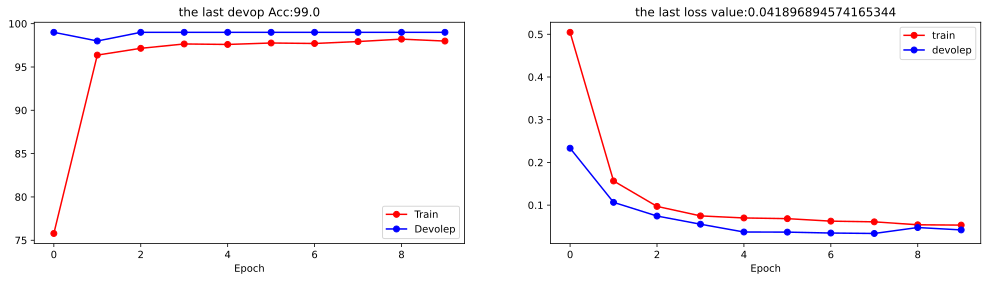

In [64]:
CNN,trainAcc,devAcc,losses,dev_losses,theAllTrainTime=trainModel(10)

fig,ax=plt.subplots(1,2,figsize=(17,4))
print(f'training completed at {theAllTrainTime:.2f}')
ax[0].plot(trainAcc,'ro-',label='Train')
ax[0].plot(devAcc,'bo-',label='Devolep')
ax[0].set_xlabel('Epoch')
ax[0].set_title(f"the last devop Acc:{devAcc[-1]}")
ax[0].legend()

ax[1].plot(losses,'ro-',label='train')
ax[1].plot(dev_losses.detach(),'bo-',label='devolep')
ax[1].set_xlabel('Epoch')
ax[1].set_title(f'the last loss value:{dev_losses[-1]}')
ax[1].legend()

plt.show()

# testing model

tensor(100.)


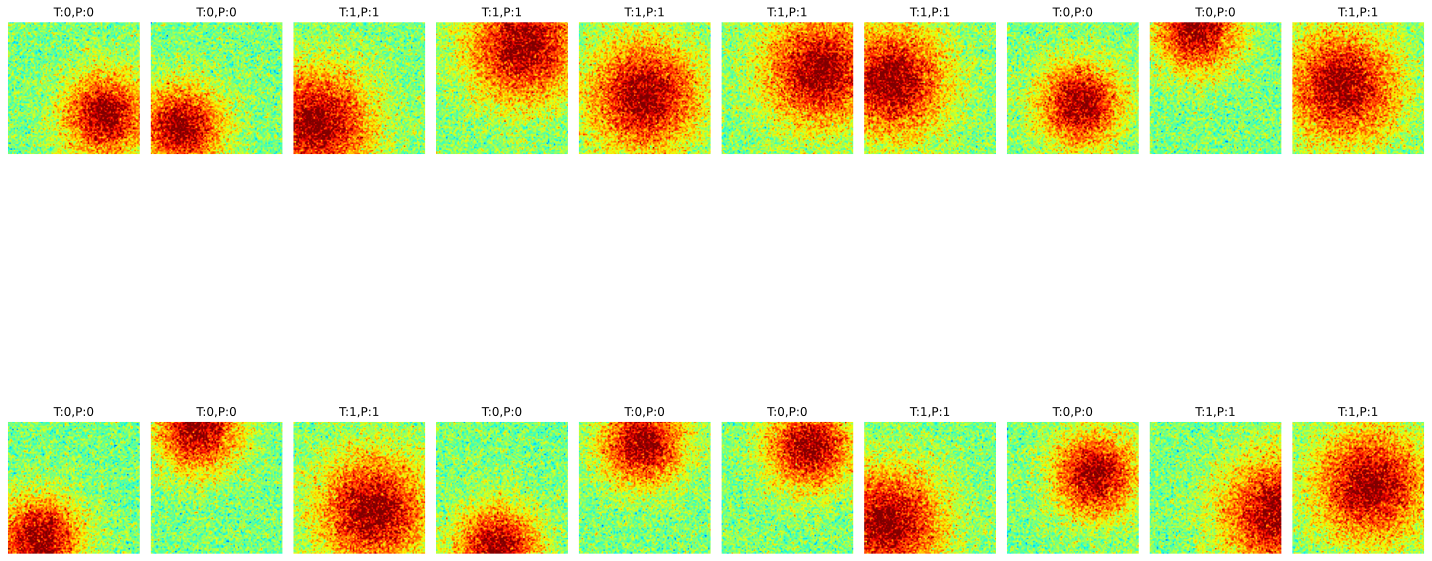

In [65]:
dat,lab=next(iter(test_loader))
CNN=CNN.cpu()
yHat=CNN(dat)

prediction=(yHat>0).float()
match=(prediction==lab).float()
accuracy=100*torch.mean(match)
print(accuracy)
fig,axs=plt.subplots(2,10,figsize=(20,15))
for ax in axs.flatten():
    index=np.random.randint(dat.shape[0])
    gaus=torch.squeeze(dat[index,0,:,:]).detach()
    ax.imshow(gaus,vmin=-1,vmax=1,cmap='jet')
    ax.set_title(f'T:{int(lab[index].item())},P:{int(prediction[index].item())}')
    ax.axis('off')
    
plt.tight_layout()
plt.show()

# look at weight values

In [93]:
print(CNN)

layer1W=CNN.network[0].weight

print(' ')
print(layer1W.shape)
print(layer1W)

cnnModel(
  (network): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=5, stride=2, padding=1)
    (3): Conv2d(6, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=5, stride=2, padding=1)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1936, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)
 
torch.Size([6, 1, 3, 3])
Parameter containing:
tensor([[[[ 0.2172,  0.3113,  0.1158],
          [-0.2027,  0.1644, -0.1207],
          [-0.0133, -0.0713,  0.2078]]],


        [[[-0.1679,  0.1156,  0.0521],
          [-0.3503, -0.2846, -0.3904],
          [-0.4099,  0.2684,  0.1799]]],


        [[[ 0.2982,  0.1836, -0.1711],
          [ 0.2915, -0.3067,  0.0855],
          [ 0.3155, -0.0205, -0.0728]]],


        [[[-0.0751, -0.3061,  0.0448],
          [-0.0639, -0.2678,  0.0698],
          [-0.2999